Imports

In [1]:
from statistics import LinearRegression
import json
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from scipy import stats

import pandas as pd
import sklearn
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model

analysis functions

In [2]:
# the simulated signals were presented in randomized order to each human labeler. The ordering was recorded as a list of indices.
# the selections the labelers made were recorded in the order they were made.
# This function finds the index at which the desired signal index appears in the ordering of signal indices.
def reverse_order_search(j, order):
    for i in range(len(order)):
        if j == order[i]:
            return i

# the linear coefficients come from a linear regression model searching for the best fit line between
# signal-noise ratio and _ratio parameter used to generate signals
def ratio_to_snr_converter(_ratio):
    snr = -19.65 * (_ratio) + 9.668
    # negative snr coefficient is due to linear regression being performed in log scale. It's in decibels so it can be negative.
    snr = snr/10.0
    snr = np.power(10, snr)
    return snr

# this decodes ONE entry in the list of params used to generate one signal.
# the function returns a dictionary with named parameters for visual inspection
# this function is only used when investigating the signal with the worst f1 score.
def decode_params(param_list) -> dict | None:
    if len(param_list) != 5:
        return None
    retDict = {}
    retDict["freq"] = 2 * param_list[0]
    retDict["n_cycles"] = param_list[1]
    retDict["rise-decay asymmetry"] = param_list[2]
    retDict["aperiodic exponent"] = param_list[3]
    retDict["signal-noise ratio"] = ratio_to_snr_converter(param_list[4])
    return retDict

# this decodes ONE entry in the list of params used to generate one signal.
# the function returns a numpy array with the same parameters as decode_params.
# this function is used when preparing data for regression analysis.
# It differs from decode_params in that it returns a numpy array instead of a dictionary.
def decode_params_np(param_list) -> dict | None:
    if len(param_list) != 5:
        return None
    retArray = np.zeros(5)
    retArray[0] = 2 * param_list[0]
    retArray[1] = param_list[1]
    retArray[2] = param_list[2]
    retArray[3] = param_list[3]
    retArray[4] = ratio_to_snr_converter(param_list[4])
    return retArray

# this function takes a list of parameters and returns a dictionary with named parameters.
# the function is used when preparing data for regression analysis.
# this function calls decode_params to ensure frequency and snr are accurate.
def param_list_to_training_data(param_list):
    num_samples = len(param_list)
    num_features = 5
    retArray = np.zeros((num_samples, num_features))
    for i in range(len(param_list)):
        row = decode_params_np(param_list[i])
        retArray[i][0:num_features] = row[:num_features]
    return retArray



Import File Data

In [3]:

# Load data from results json exported from firebase
with open("./voyteklabstudy-default-rtdb-export.json") as f:
    results = json.load(f)

Set constants

In [4]:


# this is the number of real recorded EEG signal we used in the study platform we hosted. The
# signals were arranged in (real signals, simulated signals) order. Thus, num_real_sigs is used
# as an array offset in this analysis.
num_real_sigs = 49


# ground truth has shape (num_participants,2)
# it shows the correct bursting classification.
# ground_truth[i] = [a,b] where a is true burst onset and b is true burst offset.
ground_truth = np.array(results["ground_truth"])

# List of names of human collaborators who labeled data
# length of which gives us number of labelings. Allows us to iterate through labelers
who = list(results["selections"].keys())
print(who)

'''
y_pred and y_true are variables for auc_roc
  we want to analyze humans as a whole.
  so y_pred is the interval the humans select (on average?)
  let's start with just one lab person.
'''
y_pred = np.zeros(
    (len(ground_truth), len(results['sigs']['sig_'+str(0)])))
y_true = np.zeros(
    (len(ground_truth), len(results['sigs']['sig_'+str(0)])))
scores = np.zeros(len(ground_truth))

# the classes are "bursting" and "non-bursting"
num_classes = 2




['Andrew Bender@1714089263343', 'Bradley Voytek Apr22 2024@1713819121072', 'Dillan@1713909205994', 'Eena Kosik@1713821677039', 'MJ@1714513556139', 'Quirine@1714514427397', 'Ryan Hammonds@1713819289745', 'Sydney Smith@1714416232441', 'rgao@1715689500559']


Assign one F1 Score per Signal.

We generate consensus about each timepoint in each signal.
We predict a timepoint is bursting if and only if most participants decide it is.

In [5]:

for i in range(len(ground_truth)):

    curr_sig_idx = i+num_real_sigs
    eeg_signal_profiled_in_this_loop = results['sigs']['sig_'+str(
        i+num_real_sigs)]
    
    for j in range(len(who)):
        order = np.array(results["selections"][who[j]]['indices'])
        selections = np.array(results["selections"][who[j]]["selections"])
        reverse_search_sig_idx = reverse_order_search(i + num_real_sigs, order)
        selections_indexed_by_labeler = selections[reverse_search_sig_idx]

        len_curr_sig = len(eeg_signal_profiled_in_this_loop)

        if j == 0:
            for subIndex in range(ground_truth[i][0], ground_truth[i][1]+1):
                y_true[i][subIndex] = 1

        for subIndex in range(selections_indexed_by_labeler[0], selections_indexed_by_labeler[1]+1):
            y_pred[i][subIndex] += 1

    for subindex in range(0, len(eeg_signal_profiled_in_this_loop)):
        y_pred[i][subIndex] /= len(who)

    scores[i] = sklearn.metrics.roc_auc_score(y_true=y_true[i], y_score=y_pred[i])


Analysis of the 0.0 f-score signal

worst f1 score: 0.9649758725171137 index 48
raw params: [6, 4, 0.3491894979636595, -1.0585568484689165, 0.31740143861546555]
decoded params: {'freq': 12, 'n_cycles': 4, 'rise-decay asymmetry': 0.3491894979636595, 'aperiodic exponent': -1.0585568484689165, 'signal-noise ratio': 2.2034650841485437}


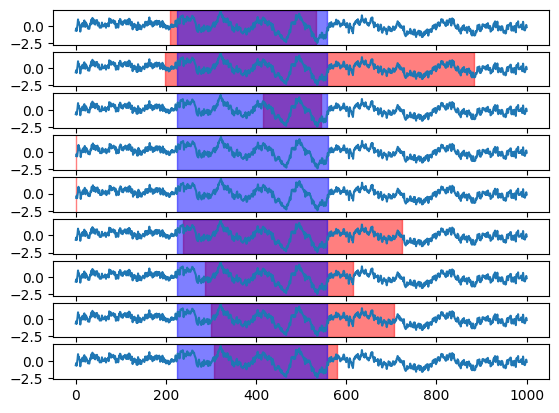

In [6]:

# identify the really bad signal.
max_val, bad_score_index = 1.0, -1
for ground_truth_signal_index in range(len(ground_truth)):
    if scores[ground_truth_signal_index] < max_val:
        max_val = scores[ground_truth_signal_index]
        bad_score_index = ground_truth_signal_index

print("worst f1 score:", scores[bad_score_index], "index", bad_score_index)
params = results["params"][bad_score_index]
print("raw params: %s" % str(params))
params = decode_params(params)
print("decoded params: %s" % params)

sig_bad_perf = results['sigs']['sig_'+str(
    bad_score_index+num_real_sigs)]
# this loop records the quantity of labelers who each timepoint in signal i as bursting
for labeler_index in range(len(who)):
    order = np.array(results["selections"][who[labeler_index]]['indices'])
    selections = np.array(results["selections"]
                          [who[labeler_index]]["selections"])

    # this block retrieves the signal selections that labeler j made on signal i.
    # then assigns this value to selections_indexed_by_labeler.
    reverse_search_sig_idx = reverse_order_search(
        bad_score_index + num_real_sigs, order)
    selections_indexed_by_labeler = selections[reverse_search_sig_idx]

    begin= 0
    end = 1
    plt.subplot(len(who), 1, labeler_index+1)
    plt.plot(np.linspace(0, len_curr_sig, len_curr_sig),
             sig_bad_perf)
    plt.axvspan(
        selections_indexed_by_labeler[begin], selections_indexed_by_labeler[end], color='red', alpha=0.5)
    plt.axvspan(ground_truth[bad_score_index][begin],
                ground_truth[bad_score_index][end], color='blue', alpha=0.5)


Data preparation for regressions on data with outliers included

In [7]:
param_data = results['params']

X = param_list_to_training_data(param_data)
y = scores.copy()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=104, test_size=0.25, shuffle=True)

print(X_test)
print(min(y), max(y))

[[18.          3.          0.32351237 -1.34016827  2.35573182]
 [10.          3.          0.2742099  -1.71454937  1.01413413]
 [10.          4.          0.24520271 -1.7000189   3.03617868]
 [16.          4.          0.44608914 -1.36665764  1.66121739]
 [16.          4.          0.49612223 -1.5126299   2.15490302]
 [12.          3.          0.3270286  -1.03815116  1.27705177]
 [14.          5.          0.24893313 -1.22608695  3.07162288]
 [14.          3.          0.40409208 -1.06626986  1.8993986 ]
 [18.          3.          0.26903812 -1.09234735  2.31559792]
 [10.          3.          0.20984328 -1.72176191  1.1771225 ]
 [10.          5.          0.25611583 -1.60194221  1.59252112]
 [12.          5.          0.33621158 -1.14587225  1.52186775]
 [16.          5.          0.303837   -1.05080384  1.19216361]]
0.9649758725171137 0.9999666942826573


Regressions first without standardizing data, then with

In [8]:

# operating on raw data

print("\nUNSCALED DATA, OUTLIERS KEPT:")
# linear regression
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
# print("linear regression params: %s" % str(regr.get_params()))
print("linear regression score: %f" % regr.score(X_test, y_test))


# SVR regression code (https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_lin.fit(X_train, y_train)
print("linear support vector regression score: %f" % svr_lin.score(X_test, y_test))

svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_rbf.fit(X_train, y_train)
print("rbf support vector regression score: %f" % svr_rbf.score(X_test, y_test))

svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
svr_poly.fit(X_train, y_train)
print("poly support vector regression score: %f" % svr_poly.score(X_test, y_test))

# Operating on scaled data
# Same models but preprocessing
# https://scikit-learn.org/1.5/modules/preprocessing.html

print("\nSCALED DATA, OUTLIERS KEPT:")
pipe1 = make_pipeline(StandardScaler(), linear_model.LinearRegression())
pipe1.fit(X_train, y_train)  # apply scaling on training data
print("linear regression score: %f" % pipe1.score(X_test, y_test))

pipe2 = make_pipeline(StandardScaler(), SVR(kernel="linear", C=100, gamma=0.1, epsilon=0.1))
pipe2.fit(X_train, y_train)  # apply scaling on training data
print("linear support vector regression score: %f" % pipe2.score(X_test, y_test))

pipe3 = make_pipeline(StandardScaler(), SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1))
pipe3.fit(X_train, y_train)  # apply scaling on training data
print("rbf support vector regression score: %f" % pipe3.score(X_test, y_test))

pipe4 = make_pipeline(StandardScaler(), SVR(kernel="poly", C=100, gamma="auto", degree=3))
pipe4.fit(X_train, y_train)  # apply scaling on training data
print("poly support vector regression score: %f" % pipe4.score(X_test, y_test))



UNSCALED DATA, OUTLIERS KEPT:
linear regression score: 0.288620
linear support vector regression score: -6.474618
rbf support vector regression score: -6.474618
poly support vector regression score: -6.474618

SCALED DATA, OUTLIERS KEPT:
linear regression score: 0.288620
linear support vector regression score: -6.474618
rbf support vector regression score: -6.474618
poly support vector regression score: -6.474618


Removing outliers

In [9]:

# removing outliers.
score_copy = np.array(scores)

z_scores = np.abs(stats.zscore(score_copy))
threshold = 3
# print("z_scores", z_scores)
indices = np.array([], dtype=int)
# print(X_test.shape)
for i in range(len(score_copy)):
    if z_scores[i]<3:
        indices = np.append(indices, i)
# print("indices", indices)

X_out = X[indices]
y_out = y[indices]
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(
    X_out, y_out, random_state=104, test_size=0.25, shuffle=True)


Apply same regressions as last time

In [10]:

print("\nUNSCALED DATA, REMOVED OUTLIERS:")

# linear regression
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print("REMOVED OUTLIERS\n")
print(regr.coef_)
print("linear regression score: %f" % regr.score(X_test_out, y_test_out))

# SVR regression code (https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_lin.fit(X_train_out, y_train_out)
print("linear support vector regression score: %f" % svr_lin.score(X_test_out, y_test_out))

svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_rbf.fit(X_train_out, y_train_out)
print("rbf svr score: %f" % svr_rbf.score(X_test_out, y_test_out))

svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
svr_poly.fit(X_train_out, y_train_out)
print("poly svr score: %f" % svr_poly.score(X_test_out, y_test_out))


print("\nSCALED DATA, REMOVED OUTLIERS:")
# Same models but preprocessing
# https://scikit-learn.org/1.5/modules/preprocessing.html
pipe1 = make_pipeline(StandardScaler(), linear_model.LinearRegression())
pipe1.fit(X_train_out, y_train_out)  # apply scaling on training data
print("linear regression score: %f" % pipe1.score(X_test_out, y_test_out))

pipe2 = make_pipeline(StandardScaler(), SVR(kernel="linear", C=100, gamma=0.1, epsilon=0.1))
pipe2.fit(X_train_out, y_train_out)  # apply scaling on training data
print("linear support vector regression score: %f" % pipe2.score(X_test_out, y_test_out))

pipe3 = make_pipeline(StandardScaler(), SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1))
pipe3.fit(X_train_out, y_train_out)  # apply scaling on training data
print("rbf support vector regression score: %f" % pipe3.score(X_test_out, y_test_out))

pipe4 = make_pipeline(StandardScaler(), SVR(kernel="poly", C=100, gamma="auto", degree=3))
pipe4.fit(X_train_out, y_train_out)  # apply scaling on training data
print("poly svr score: %f" % pipe4.score(X_test_out, y_test_out))

# print(param_data)
param_dict = decode_params(X.T)
param_df = pd.DataFrame(param_dict)
param_df.to_json("roc_param_df.json")

scores_df = pd.DataFrame(scores)
scores_df.to_json("roc_scores_df.json")

indices_not_outliers = pd.DataFrame(indices)
indices_not_outliers.to_json("roc_indices_not_outliers.json")
print("indices_df", indices_not_outliers)



UNSCALED DATA, REMOVED OUTLIERS:
REMOVED OUTLIERS

[ 0.00043086  0.00031501  0.004128   -0.00706389  0.0004788 ]
linear regression score: 0.194943
linear support vector regression score: -0.746939
rbf svr score: -0.746939
poly svr score: -0.746939

SCALED DATA, REMOVED OUTLIERS:
linear regression score: 0.172959
linear support vector regression score: -0.746939
rbf support vector regression score: -0.746939
poly svr score: -0.746939
indices_df      0
0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
8    8
9    9
10  10
11  11
12  12
13  13
14  14
15  15
16  16
17  17
18  18
19  19
20  20
21  21
22  22
23  23
24  24
25  25
26  26
27  27
28  28
29  29
30  30
31  31
32  32
33  33
34  34
35  35
36  36
37  37
38  38
39  39
40  40
41  41
42  42
43  43
44  44
45  45
46  46
47  47
48  49
